In [271]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../..'))

from emlp.groups import Z,S,SO,O,O13,SO13,RubiksCube, noise2samples


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constructing Equivariant Models

Previously we showed examples of finding equivariant bases for different groups and representations, now we'll show how these bases can be assembled into equivariant neural networks such as EMLP. 

We will give examples at a high level showing how the specific EMLP model can be applied to different groups and input-output types, and later in a lower level showing how models like EMLP can be constructed with equivariant layers and making use of the equivariant bases.

## Using EMLP with different groups and representations (high level)

![ex 2.13](imgs/EMLP_fig.png)

A basic EMLP is a sequence of EMLP layers (containing G-equivariant linear layers, bilinear layers incorporated with a shortcut connection, and gated nonlinearities. While our numerical equivariance solver can work with any finite dimensional linear representation, for EMLP we restrict ourselves to _tensor_ representations.

By tensor representations, we mean all representations which can be formed by arbitrary combinations of $\oplus$,$\otimes$,$^*$ (`+`,`*`,`.T`) of a base representation $\rho$. This is useful because it simplifies the construction of our bilinear layer, which is a crucial ingredient for expressiveness and universality in EMLP.

Following the $T_{(p,q)}=V^{\otimes p}\otimes (V^*)^{\otimes p}$ notation in the paper, we provide the convenience function for constructing higher rank tensors.

In [2]:
from emlp.reps import V, vis
from emlp.groups import SO13

def T(p,q=0):
    return (V**p*V.T**q)

print(T(2,3))
print(T(2,3)(SO13()))

/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


V⊗V⊗V*⊗V*⊗V*
V²⊗V*³


Lets get started with a toy dataset: learning how an inertia matrix depends on the positions and masses of 5 point masses distributed in different ways. The data consists of mappings (positions, masses) --> (inertia matrix) pairs, and has an $G=O(3)$ symmetry (3D rotation and reflections). If we rotate all the positions, the resulting inertia matrix should be correspondingly rotated.

In [291]:
from emlp.datasets import Inertia
from emlp.groups import SO,O,S,Z

trainsize, testsize = 1000, 2000 # original size
trainsize, testsize = 100, 200   # tiny set for development

trainset = Inertia(trainsize) # Initialize dataset with 1000 examples
testset  = Inertia(testsize)
G = SO(3)
G = O(3)
print(f"Input type: {trainset.rep_in(G)}, output type: {trainset.rep_out(G)}")

print([d.shape for d in trainset[0]])

Input type: 5V⁰+5V, output type: V²
[(20,), (9,)]


In [292]:
# G=Z(4)
# G = T(3)
# G = S(3)


# N = 1
# A_dense = jnp.stack([Ai@jnp.eye(G.d) for Ai in G.lie_algebra]) if len(G.lie_algebra) else jnp.zeros((0,G.d,G.d))
# h_dense = jnp.stack([hi@jnp.eye(G.d) for hi in G.discrete_generators]) if len(G.discrete_generators) else jnp.zeros((0,G.d,G.d))
# z = np.random.randn(N,A_dense.shape[0])
# if G.z_scale is not None:
#     z*= G.z_scale
# k = np.random.randint(-5,5,size=(N,h_dense.shape[0],3))
# jax_seed= np.random.randint(100)

# noise2samples(z,k,A_dense,h_dense,jax_seed)

In [267]:
trainset.rep_in(G).size(), trainset.rep_out(G).size()

(20, 9)

In [336]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def vis_basis2(basis,shape,cluster=True):
    Q=basis@jnp.eye(basis.shape[-1]) # convert to a dense matrix if necessary
    v = np.random.randn(Q.shape[0])  # sample random vector
    v = Q@(Q.T@v)                    # project onto equivariant subspace
    if cluster: # cluster nearby values for better color separation in plot
        v = KMeans(n_clusters=Q.shape[-1]).fit(v.reshape(-1,1)).labels_
    plt.imshow(v.reshape(shape))
    plt.axis('off')
    plt.show()
    return v.reshape(shape)

def vis2(repin,repout,cluster=True):
    Q = (repin>>repout).equivariant_basis() # compute the equivariant basis
    vis_basis2(Q,(repout.size(),repin.size()),cluster) # visualize it

Conv basis has shape (180, 5)


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


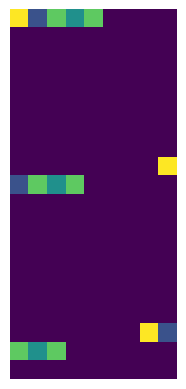

(20, 9)


array([[4, 1, 3, 2, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 4],
       [1, 3, 2, 3, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 4, 1],
       [3, 2, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [343]:
repin, repout = trainset.rep_in(G), trainset.rep_out(G)
basis = conv_basis = (repin>>repout).equivariant_basis()
print(f"Conv basis has shape {conv_basis.shape}")

v = vis_basis2(conv_basis,(repin.size(),repout.size()))
print(v.shape)

# Q=conv_basis@jnp.eye(conv_basis.shape[-1]) # convert to a dense matrix if necessary
# print(Q.shape)
# plt.imshow(Q, aspect='auto')
# plt.show()
v

Conv basis has shape (180, 5)


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(20, 9)

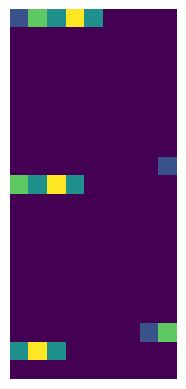

In [268]:
rep = (trainset.rep_in(G)>>trainset.rep_out(G))
v = np.random.randn(rep.size())
g = G.sample()
print(f"𝜌(g) =\n{rep.rho(g)}")

𝜌(g) =
<180x180 _ProductLinearOperator with dtype=float32>


In [230]:
# gs = np.array([G.sample() for _ in range(100)])
# rho_gs = np.array([rep.rho(g) for g in gs])

# plt.imshow(np.mean(rho_gs, axis=0))
# plt.colorbar()
# plt.show()

In [231]:
v = np.random.randn(rep.size())
g = G.sample()
print(f"𝜌(g) =\n{rep.rho(g)}")
print(f"v = {v}")
print(f"𝜌(g)v = {rep.rho(g)@v:}")

𝜌(g) =
[[-0.5179793  -0.67944866 -0.5196604 ]
 [-0.5248502   0.73215973 -0.4341363 ]
 [-0.6754478  -0.04787027  0.73585236]]
v = [-1.36722903 -1.2087752  -1.18169822]
𝜌(g)v = [2.1435788  0.345592   0.11180079]


For convenience, we store in the dataset the types for the input and the output. `5V⁰` are the $5$ mass values and `5V` are the position vectors of those masses, `V²` is the matrix type for the output, equivalent to $T_2$. To initialize the [EMLP](https://emlp.readthedocs.io/en/latest/package/emlp.nn.html#emlp.nn.EMLP), we just need these input and output representations, the symmetry group, and the size of the network as parametrized by number of layers and number of channels (the dimension of the feature representation).

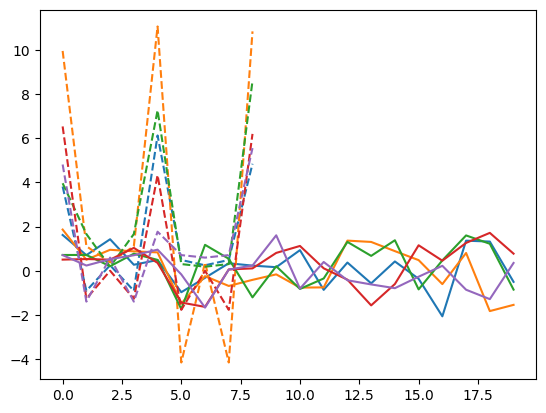

In [4]:
xs, ys = trainset[:5]
for i, (x, y) in enumerate(zip(xs, ys)):
    plt.plot(x, color = f'C{i}')
    plt.plot(y, color = f'C{i}', linestyle='--')
plt.show()

(20, 9)


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[4, 2, 1, 3, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 4],
       [2, 1, 3, 3, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 4, 2],
       [1, 3, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

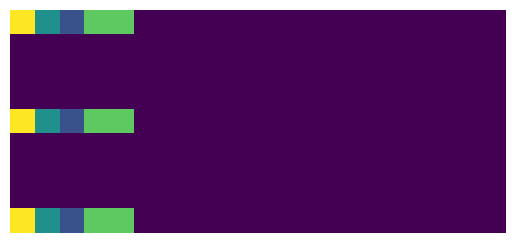

In [255]:
repin, repout = trainset.rep_in(G), trainset.rep_out(G)
# repin, repout = V(G), V(G)

v = vis(repin, repout, cluster = True)
shape = (repin.size(),repout.size())
print(shape)
v.reshape(shape)

(20, 9)


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[1, 2, 3, 4, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [2, 3, 4, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 2],
       [3, 4, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

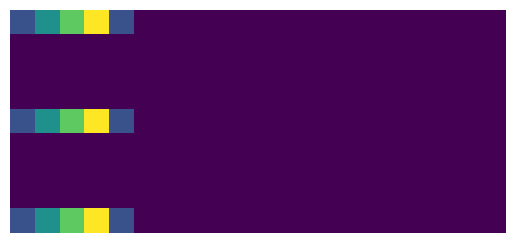

In [6]:
repin, repout = trainset.rep_in(G), trainset.rep_out(G)
# repin, repout = V(G), V(G)

v = vis(repin, repout)
shape = (repin.size(),repout.size())
print(shape)
v.reshape(shape)

In [157]:
import emlp
from emlp.nn import gated
# model = emlp.nn.EMLP(trainset.rep_in,trainset.rep_out,group=G,num_layers=3,ch=384)
model = emlp.nn.EMLP(trainset.rep_in,trainset.rep_out,group=G,num_layers=3,ch=25)
# uncomment the following line to instead try the MLP baseline
# model = emlp.nn.MLP(trainset.rep_in,trainset.rep_out,group=G,num_layers=3,ch=384)

INFO:root:Initing EMLP (objax)
INFO:root:Reps: [5V⁰+5V, 13V⁰+4V, 13V⁰+4V, 13V⁰+4V]
INFO:root:Adding gates to 13V⁰+4V, chrep is SumRep
INFO:root:Linear W components:580 rep:85V⁰+105V+20V²
INFO:root:Adding gates to 13V⁰+4V, chrep is SumRep
INFO:root:Adding gates to 13V⁰+4V, chrep is SumRep
INFO:root:BiW components: dim:408
INFO:root:Adding gates to 13V⁰+4V, chrep is SumRep
INFO:root:Linear W components:725 rep:221V⁰+120V+16V²
INFO:root:Adding gates to 13V⁰+4V, chrep is SumRep
INFO:root:Adding gates to 13V⁰+4V, chrep is SumRep
INFO:root:BiW components: dim:408
INFO:root:Adding gates to 13V⁰+4V, chrep is SumRep
INFO:root:Linear W components:725 rep:221V⁰+120V+16V²
INFO:root:Adding gates to 13V⁰+4V, chrep is SumRep
INFO:root:Adding gates to 13V⁰+4V, chrep is SumRep
INFO:root:BiW components: dim:408
INFO:root:Linear W components:225 rep:13V²+4V³


## Example Objax Training Loop

We build our EMLP model with [objax](https://objax.readthedocs.io/en/latest/) because we feel the object oriented design makes building complicated layers easier. Below is a minimal training loop that you could use to train EMLP.

In [158]:
[(rep, rep.size()) for rep in model.reps]

[(5V⁰+5V, 20), (13V⁰+4V, 25), (13V⁰+4V, 25), (13V⁰+4V, 25)]

In [159]:
model.rep_out.size()

9

In [160]:
gated(model.network[0].rep_out).size()

INFO:root:Adding gates to 13V⁰+4V, chrep is SumRep


29

In [161]:
layer = model.network[0].linear
out = layer(x)
x.shape, out.shape

((29, 20), (29, 29))

In [155]:
layer.Pb.shape

(29, 29)

(20, 29)


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (104) found smaller than n_clusters (105). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


array([[  2,  64,  52,  75,  35,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,  77,   5,  74,  69,  42,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  33,  56,
         87,  54,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,  80,  50,  91,  32,  16,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  58,  72,  45,  92,
         98,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         36,  17,  20,  43,  30,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,  38, 103,  79,  60,  85,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  87,
         59,  78,  21],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  97,  81,  61,  96,  25,   0,   0,   0,   0,   0,   0,
    

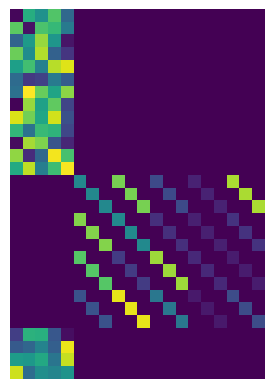

In [168]:
v = vis(layer.repin, layer.repout)
shape = (layer.repin.size(),layer.repout.size())
print(shape)
v.reshape(shape)

In [191]:
g = G.sample()
g

Array([[ 0.28608593, -0.85977507, -0.4230151 ],
       [ 0.57210416,  0.5074075 , -0.644387  ],
       [ 0.7686688 , -0.05765864,  0.6370429 ]], dtype=float32)

In [188]:
print(f"𝜌(g) =\n{repin.rho(g)}")

𝜌(g) =
<20x20 _ProductLinearOperator with dtype=float32>


In [190]:
rep = V(G)
rep = repin
v = np.random.randn(rep.size())
g = G.sample()
print(f"𝜌(g) =\n{rep.rho(g)}")


𝜌(g) =
<20x20 _ProductLinearOperator with dtype=float32>


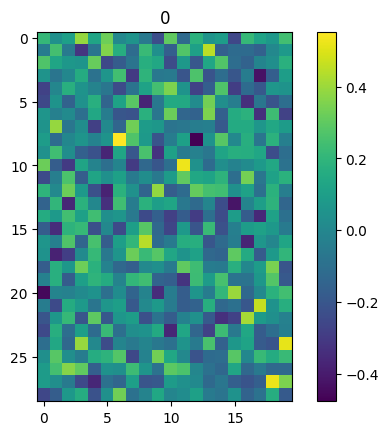

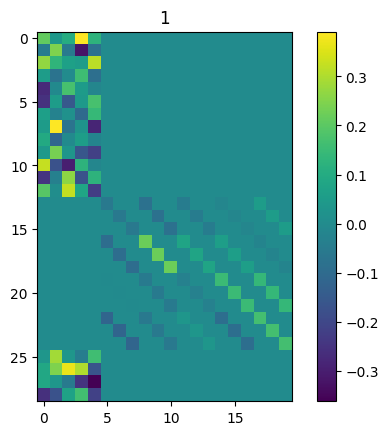

In [147]:
xs = [
    layer.w.value,
    (layer.Pw@layer.w.value.reshape(-1)).reshape(*layer.w.value.shape),
]

for i, x in enumerate(xs):
    plt.imshow(x)
    plt.colorbar()
    plt.title(f"{i}")
    plt.show()

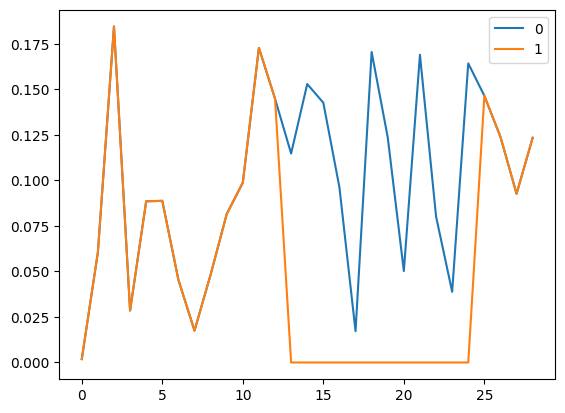

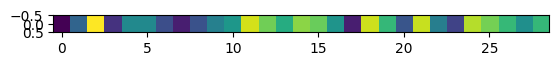

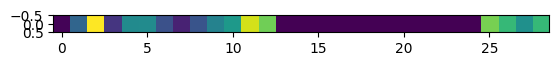

In [143]:
xs = [
    layer.b.value.reshape(1, -1),
    # layer.Pb,
    (layer.Pb@layer.b.value).reshape(1, -1),
]

for i, x in enumerate(xs):
    plt.plot(x.T, label = f"{i}")
plt.legend()
plt.show()

for x in xs:
    plt.imshow(x)
    plt.show()

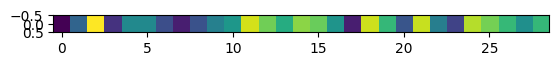

In [133]:
(layer.Pb@layer.b.value).shape

(29,)

In [ ]:
plt.imshow(layer.b.value.reshape(1, -1))


In [126]:
layer.Pb * ones

TypeError: unsupported operand type(s) for @: 'ArrayImpl' and 'Tensor'

In [26]:
BS=500
lr=3e-3
NUM_EPOCHS=500 # original
NUM_EPOCHS=50 # original

import objax
import jax.numpy as jnp
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader


opt = objax.optimizer.Adam(model.vars())

@objax.Jit
@objax.Function.with_vars(model.vars())
def loss(x, y):
    yhat = model(x)
    return ((yhat-y)**2).mean()

grad_and_val = objax.GradValues(loss, model.vars())

@objax.Jit
@objax.Function.with_vars(model.vars()+opt.vars())
def train_op(x, y, lr):
    g, v = grad_and_val(x, y)
    opt(lr=lr, grads=g)
    return v

trainloader = DataLoader(trainset,batch_size=BS,shuffle=True)
testloader = DataLoader(testset,batch_size=BS,shuffle=True)

DEBUG:jax._src.dispatch:Finished tracing + transforming broadcast_in_dim for pjit in 0.00017404556274414062 sec
DEBUG:jax._src.interpreters.pxla:Compiling broadcast_in_dim for with global shapes and types [ShapedArray(float32[])]. Argument mapping: (GSPMDSharding({replicated}),).
DEBUG:jax._src.dispatch:Finished jaxpr to MLIR module conversion jit(broadcast_in_dim) in 0.0011849403381347656 sec
DEBUG:jax._src.compiler:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=[[CpuDevice(id=0)]]
DEBUG:jax._src.compiler:get_compile_options XLA-AutoFDO profile: using XLA-AutoFDO profile version -1
DEBUG:jax._src.dispatch:Finished XLA compilation of jit(broadcast_in_dim) in 0.0057811737060546875 sec
DEBUG:jax._src.dispatch:Finished tracing + transforming broadcast_in_dim for pjit in 0.00016999244689941406 sec
DEBUG:jax._src.interpreters.pxla:Compiling broadcast_in_dim for with global shapes and types [ShapedArray(float32[])]. Argument mapping: (GSPMDSharding({replicated}),).
DE

In [22]:
batch = next(iter(trainloader))
print(len(batch))
print([b.shape for b in batch])


2
[torch.Size([100, 20]), torch.Size([100, 9])]


In [67]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

In [24]:
test_losses = []
train_losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    train_losses.append(np.mean([train_op(jnp.array(x),jnp.array(y),lr) for (x,y) in trainloader]))
    if not epoch%10:
        test_losses.append(np.mean([loss(jnp.array(x),jnp.array(y)) for (x,y) in testloader]))

  0%|          | 0/50 [00:00<?, ?it/s]DEBUG:jax._src.dispatch:Finished tracing + transforming jit for pjit in 0.004770994186401367 sec
DEBUG:jax._src.dispatch:Finished tracing + transforming jit for pjit in 0.03769493103027344 sec
DEBUG:jax._src.interpreters.pxla:Compiling jit for with global shapes and types [ShapedArray(uint32[]), ShapedArray(float32[384]), ShapedArray(float32[20,384]), ShapedArray(float32[384]), ShapedArray(float32[384,384]), ShapedArray(float32[384]), ShapedArray(float32[384,384]), ShapedArray(float32[9]), ShapedArray(float32[384,9]), ShapedArray(float32[384]), ShapedArray(float32[20,384]), ShapedArray(float32[384]), ShapedArray(float32[384,384]), ShapedArray(float32[384]), ShapedArray(float32[384,384]), ShapedArray(float32[9]), ShapedArray(float32[384,9]), ShapedArray(float32[384]), ShapedArray(float32[20,384]), ShapedArray(float32[384]), ShapedArray(float32[384,384]), ShapedArray(float32[384]), ShapedArray(float32[384,384]), ShapedArray(float32[9]), ShapedArray(f

(100, 20)
(100, 9)
(200, 20)
(200, 9)


DEBUG:jax._src.dispatch:Finished XLA compilation of jit(jit) in 0.018971920013427734 sec
100%|██████████| 50/50 [00:00<00:00, 138.55it/s]


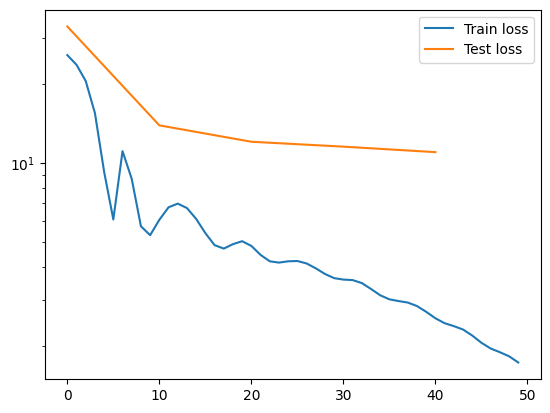

In [11]:
import matplotlib.pyplot as plt
plt.plot(np.arange(NUM_EPOCHS),train_losses,label='Train loss')
plt.plot(np.arange(0,NUM_EPOCHS,10),test_losses,label='Test loss')
plt.legend()
plt.yscale('log')

In [12]:
from jax import vmap
def rel_err(a,b):
    return jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean()))#

rin,rout = trainset.rep_in(G),trainset.rep_out(G)

def equivariance_err(mb):
    x,y = mb
    x,y= jnp.array(x),jnp.array(y)
    gs = G.samples(x.shape[0])
    rho_gin = vmap(rin.rho_dense)(gs)
    rho_gout = vmap(rout.rho_dense)(gs)
    y1 = model((rho_gin@x[...,None])[...,0],training=False)
    y2 = (rho_gout@model(x,training=False)[...,None])[...,0]
    return rel_err(y1,y2)

As expected, the network continues to be equivariant as it is trained.

In [13]:
print(f"Average test equivariance error {np.mean([equivariance_err(mb) for mb in testloader]):.2e}")

(200, 20)
(200, 9)
(200, 20)
(200, 9)
Average test equivariance error 2.17e-01


## Breaking EMLP down into equivariant layers (mid level)

Internally for EMLP, we use representations that [uniformly allocate dimensions](https://emlp.readthedocs.io/en/latest/package/emlp.models.mlp.html#emlp.models.uniform_rep) between different tensor representations.

In [14]:
from emlp.nn import uniform_rep
r = uniform_rep(512,G)
print(r)

122V⁰+40V+12V²+3V³+V⁴


Below is a trimmed down version of EMLP, so you can see how it is built from the component layers `Linear`, `BiLinear`, and `GatedNonlinearities`. These layers can be constructed like ordinary objax modules, using the input and output representations.

In [15]:
from objax.module import Module

class EMLPBlock(Module):
    """ Basic building block of EMLP consisting of G-Linear, biLinear,
        and gated nonlinearity. """
    def __init__(self,rep_in,rep_out):
        super().__init__()
        rep_out_wgates = emlp.nn.gated(rep_out)
        self.linear = emlp.nn.Linear(rep_in,rep_out_wgates)
        self.bilinear = emlp.nn.BiLinear(rep_out_wgates,rep_out_wgates)
        self.nonlinearity = emlp.nn.GatedNonlinearity(rep_out)
    def __call__(self,x):
        lin = self.linear(x)
        preact =self.bilinear(lin)+lin
        return self.nonlinearity(preact)

class EMLP(Module):
    def __init__(self,rep_in,rep_out,group,ch=384,num_layers=3):
        super().__init__()
        reps = [rep_in(group)]+num_layers*[uniform_rep(ch,group)]
        self.network = emlp.nn.Sequential(
            *[EMLPBlock(rin,rout) for rin,rout in zip(reps,reps[1:])],
            emlp.nn.Linear(reps[-1],rep_out(group))
        )
    def __call__(self,x,training=True):
        return self.network(x)

The representations of the hidden layers (taking place of the number of channels in a standard MLP) is by default given by this `uniform_rep` shown above. Unlike this pedagogical implementation you can specify the representation of the hidden layers directly in the [full EMLP](https://emlp.readthedocs.io/en/latest/package/emlp.nn.html#emlp.nn.EMLP) by feeding in a representation to the `ch` argument, or even a list of representations to specify each hidden layer.

Note that since we are using the `GatedNonlinearity`, additional scalar gate channels need to be added to the output representation for the layer directly before the nonlinearity (in this case the `Linear` layer) which can be achieved with the `gated` function.

## The equivariant linear layers (low level)

At a lower level, the implementation of the `Linear` is fairly straightforward. An unconstrained bias `b` and weight matrix `w` are initialized. The projection matrices $P_b$ and $P_w$ are computed which are used project onto the symmetric subspace for each. Finally, during the forward pass, the unconstrained parameters are reshaped to vectors, projected via the matrices, and reshaped back to the original sizes. Then these projected parameters are applied to the input like a standard linear layer.

In [16]:
from objax.variable import TrainVar
from objax.nn.init import orthogonal

class Linear(Module):
    """ Basic equivariant Linear layer from repin to repout."""
    def __init__(self, repin, repout):
        nin,nout = repin.size(),repout.size()
        self.b = TrainVar(objax.random.uniform((nout,))/jnp.sqrt(nout))
        self.w = TrainVar(orthogonal((nout, nin)))
        self.rep_W = rep_W = repout*repin.T
        
        self.Pb = repout.equivariant_projector() # the bias vector has representation repout
        self.Pw = rep_W.equivariant_projector()
        
    def __call__(self, x):
        W = (self.Pw@self.w.value.reshape(-1)).reshape(*self.w.value.shape)
        b = self.Pb@self.b.value
        return x@W.T+b